In [1]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import matplotlib.pyplot as plt
import copy
import numpy as np
import random
from torch.optim import LBFGS
from tqdm import tqdm
import scipy.io

In [2]:


def get_data(x_range, y_range, x_num, y_num):
    x = np.linspace(x_range[0], x_range[1], x_num)
    t = np.linspace(y_range[0], y_range[1], y_num)

    x_mesh, t_mesh = np.meshgrid(x,t)
    data = np.concatenate((np.expand_dims(x_mesh, -1), np.expand_dims(t_mesh, -1)), axis=-1)
    
    b_left = data[0,:,:] 
    b_right = data[-1,:,:]
    b_upper = data[:,-1,:]
    b_lower = data[:,0,:]
    res = data.reshape(-1,2)

    return res, b_left, b_right, b_upper, b_lower



def make_time_sequence(src, num_step=5, step=1e-4):
    dim = num_step
    src = np.repeat(np.expand_dims(src, axis=1), dim, axis=1)  # (N, L, 2)
    for i in range(num_step):
        src[:,i,-1] += step*i
    return src

In [3]:
# implementation of PINNsformer
# paper: PINNsFormer: A Transformer-Based Framework For Physics-Informed Neural Networks
# link: https://arxiv.org/abs/2307.11833



torch.manual_seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

def get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

class WaveAct(nn.Module):
    def __init__(self):
        super(WaveAct, self).__init__() 
        self.w1 = nn.Parameter(torch.ones(1), requires_grad=True)
        self.w2 = nn.Parameter(torch.ones(1), requires_grad=True)

    def forward(self, x):
        return self.w1 * torch.sin(x)+ self.w2 * torch.cos(x)

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=256):
        super(FeedForward, self).__init__() 
        self.linear = nn.Sequential(*[
            nn.Linear(d_model, d_ff),
            WaveAct(),
            nn.Linear(d_ff, d_ff),
            WaveAct(),
            nn.Linear(d_ff, d_model)
        ])

    def forward(self, x):
        return self.linear(x)


class EncoderLayer(nn.Module):
    def __init__(self, d_model, heads):
        super(EncoderLayer, self).__init__()

        self.attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=heads, batch_first=True)
        self.ff = FeedForward(d_model)
        self.act1 = WaveAct()
        self.act2 = WaveAct()
        
    def forward(self, x):
        x2 = self.act1(x)
        # pdb.set_trace()
        x = x + self.attn(x2,x2,x2)[0]
        x2 = self.act2(x)
        x = x + self.ff(x2)
        return x


class DecoderLayer(nn.Module):
    def __init__(self, d_model, heads):
        super(DecoderLayer, self).__init__()

        self.attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=heads, batch_first=True)
        self.ff = FeedForward(d_model)
        self.act1 = WaveAct()
        self.act2 = WaveAct()

    def forward(self, x, e_outputs): 
        x2 = self.act1(x)
        x = x + self.attn(x2, e_outputs, e_outputs)[0]
        x2 = self.act2(x)
        x = x + self.ff(x2)
        return x


class Encoder(nn.Module):
    def __init__(self, d_model, N, heads):
        super(Encoder, self).__init__()
        self.N = N
        self.layers = get_clones(EncoderLayer(d_model, heads), N)
        self.act = WaveAct()

    def forward(self, x):
        for i in range(self.N):
            x = self.layers[i](x)
        return self.act(x)


class Decoder(nn.Module):
    def __init__(self, d_model, N, heads):
        super(Decoder, self).__init__()
        self.N = N
        self.layers = get_clones(DecoderLayer(d_model, heads), N)
        self.act = WaveAct()
        
    def forward(self, x, e_outputs):
        for i in range(self.N):
            x = self.layers[i](x, e_outputs)
        return self.act(x)



class PINNsformer(nn.Module):
    def __init__(self, d_out, d_model, d_hidden, N, heads):
        super(PINNsformer, self).__init__()

        self.linear_emb = nn.Linear(2, d_model)

        self.encoder = Encoder(d_model, N, heads)
        self.decoder = Decoder(d_model, N, heads)
        self.linear_out = nn.Sequential(*[
            nn.Linear(d_model, d_hidden),
            WaveAct(),
            nn.Linear(d_hidden, d_hidden),
            WaveAct(),
            nn.Linear(d_hidden, d_out)
        ])

    def forward(self, x, t):
        src = torch.cat((x,t), dim=-1)
        src = self.linear_emb(src)

        e_outputs = self.encoder(src)
        d_output = self.decoder(src, e_outputs)
        output = self.linear_out(d_output)
        # pdb.set_trace()
        # raise Exception('stop')
        return output

Using cuda


In [4]:
T_periode=0.2
def get_density(t):
    """
    Returns the density (as a PyTorch tensor) based on time t (in seconds).
    Supports scalar or batch tensor input.
    
    Parameters:
        t (torch.Tensor): Time(s) in seconds.
        
    Returns:
        torch.Tensor: Density (kg/m³), same shape as t.
    """
    t = torch.as_tensor(t, dtype=torch.float32)
    cycle_position = torch.floor(t /T_periode).to(torch.int32)
    
    # Even cycles → water (1000), Odd cycles → phosphate (1800)
    density = torch.where(cycle_position % 2 == 0,
                          torch.tensor(1),
                          torch.tensor(1.6))
    return density

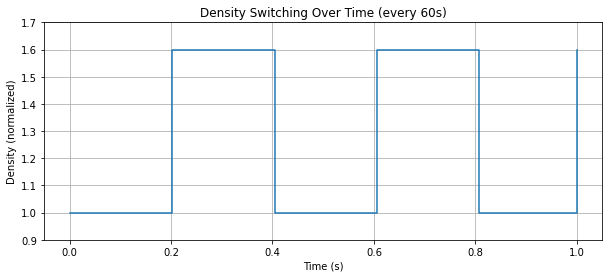

In [5]:
# Generate time values from 0 to 600 seconds
t_values = torch.linspace(0,1 , steps=100)
density_values = get_density(t_values)

# Plot
plt.figure(figsize=(10, 4))
plt.plot(t_values, density_values, drawstyle='steps-post')
plt.xlabel("Time (s)")
plt.ylabel("Density (normalized)")
plt.title("Density Switching Over Time (every 60s)")
plt.grid(True)
plt.ylim(0.9, 1.7)
plt.show()

In [6]:
# -----------------------------------------------------------------------------
# Training data (collocation + IC + BC)
# -----------------------------------------------------------------------------
T_final = 1
L_finale=1
N_f = 101 # interior collocation points
N_i = 51     # initial‑condition points
N_b = 51    # boundary‑condition points
Beta = 1

Rho_i=1


# Train PINNsFormer
res, b_t_initial, b_t_final, b_x_end, b_x_start = get_data([0, L_finale], [0, T_final], 51, 51)
res_test, _, _, _, _ = get_data([0, T_final], [0, T_final], 101, 101)

# Generate pseudo-sequences for time-stepping
res = make_time_sequence(res, num_step=5, step=1e-4)
b_t_initial = make_time_sequence(b_t_initial, num_step=5, step=1e-4)
b_t_final = make_time_sequence(b_t_final, num_step=5, step=1e-4)
b_x_end = make_time_sequence(b_x_end, num_step=5, step=1e-4)
b_x_start = make_time_sequence(b_x_start, num_step=5, step=1e-4)

# Convert to PyTorch tensors
res = torch.tensor(res, dtype=torch.float32, requires_grad=True).to(device)
b_t_initial = torch.tensor(b_t_initial, dtype=torch.float32, requires_grad=True).to(device)
b_t_final = torch.tensor(b_t_final, dtype=torch.float32, requires_grad=True).to(device)
b_x_end = torch.tensor(b_x_end, dtype=torch.float32, requires_grad=True).to(device)
b_x_start = torch.tensor(b_x_start, dtype=torch.float32, requires_grad=True).to(device)

# Separate x and t components
x_res, t_res = res[:, :, 0:1], res[:, :, 1:2]
x_t_initial, t_t_initial = b_t_initial[:, :, 0:1], b_t_initial[:, :, 1:2]
x_t_final, t_t_final = b_t_final[:, :, 0:1], b_t_final[:, :, 1:2]
x_x_end, t_x_end = b_x_end[:, :, 0:1], b_x_end[:, :, 1:2]
x_x_start, t_x_start = b_x_start[:, :, 0:1], b_x_start[:, :, 1:2]


In [7]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

model = PINNsformer(d_out=1, d_hidden=512, d_model=32, N=1, heads=2).to(device)

model.apply(init_weights)

optim = LBFGS(model.parameters(), line_search_fn='strong_wolfe')

print(model)



<ipython-input-7-2a4d00c84d58>:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


PINNsformer(
  (linear_emb): Linear(in_features=2, out_features=32, bias=True)
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (ff): FeedForward(
          (linear): Sequential(
            (0): Linear(in_features=32, out_features=256, bias=True)
            (1): WaveAct()
            (2): Linear(in_features=256, out_features=256, bias=True)
            (3): WaveAct()
            (4): Linear(in_features=256, out_features=32, bias=True)
          )
        )
        (act1): WaveAct()
        (act2): WaveAct()
      )
    )
    (act): WaveAct()
  )
  (decoder): Decoder(
    (layers): ModuleList(
      (0): DecoderLayer(
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (ff): FeedForward(
          (linear): Sequen

In [16]:
def pde_residual(model: nn.Module, x: torch.Tensor, t: torch.Tensor,a=Beta):
    """Compute residual f(x,t) = ∂u/∂t + a ∂u/∂x."""
    x.requires_grad_(True)
    t.requires_grad_(True)

    u = model(x, t)
    # ∂u/∂t
    u_t = torch.autograd.grad(u, t,
                        grad_outputs=torch.ones_like(u),
                        create_graph=True,
                        retain_graph=True )[0]
    # ∂u/∂x
    u_x = torch.autograd.grad(u, x,
                        grad_outputs=torch.ones_like(u),
                        create_graph=True,
                        retain_graph=True )[0]

    return u_t + a * u_x  # residual should be ≈ 0

In [ ]:
def loss_components(model):
    """Returns individual MSE losses: residual, IC, BC."""
    f = pde_residual(model, x_res, t_res,Beta)

    u_pred_i = model(x_t_initial, t_t_initial)


    u_pred_b_start = model(x_x_start, t_x_start)
    loss_f = torch.mean(f ** 2)
    loss_i = torch.mean((u_pred_i[:,0] - Rho_i) ** 2)
    loss_b = torch.mean((u_pred_b_start - get_density(x_x_start)) ** 2)


    return  loss_f, loss_i, loss_b

In [30]:
model2 = PINNsformer(d_out=1, d_hidden=512, d_model=32, N=1, heads=2).to(device)

model2.apply(init_weights)

optim2 = LBFGS(model2.parameters(), line_search_fn='strong_wolfe')


<ipython-input-7-2a4d00c84d58>:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


In [31]:


def closure():
    optim.zero_grad()
    lf, li, lb = loss_components(model)  # All model calls and loss calculations inside
    loss = lf + li + lb
    loss.backward()
    return loss



for i in tqdm(range(500)):
    optim.step(closure)
    # If you want to print losses, recompute them OUTSIDE the closure, not inside
    if i % 50 == 0:
        lf, li, lb = loss_components(model)
        loss = lf + li + lb
        print(f"Step {i}: total={loss.item()} (res={lf.item()}, IC={li.item()}, BC={lb.item()})")

        
        

  0%|          | 2/500 [00:00<00:31, 15.67it/s]

Step 0: total=9.844696933214436e-07 (res=8.723474707039713e-07, IC=1.90420816892356e-08, BC=9.308008941388835e-08)


 11%|█         | 53/500 [00:02<00:22, 20.30it/s]

Step 50: total=9.844696933214436e-07 (res=8.723474707039713e-07, IC=1.90420816892356e-08, BC=9.308008941388835e-08)


 21%|██        | 104/500 [00:05<00:19, 20.53it/s]

Step 100: total=9.844696933214436e-07 (res=8.723474707039713e-07, IC=1.90420816892356e-08, BC=9.308008941388835e-08)


 31%|███       | 155/500 [00:07<00:16, 20.52it/s]

Step 150: total=9.844696933214436e-07 (res=8.723474707039713e-07, IC=1.90420816892356e-08, BC=9.308008941388835e-08)


 41%|████      | 203/500 [00:09<00:14, 20.38it/s]

Step 200: total=9.844696933214436e-07 (res=8.723474707039713e-07, IC=1.90420816892356e-08, BC=9.308008941388835e-08)


 51%|█████     | 254/500 [00:12<00:12, 20.47it/s]

Step 250: total=9.844696933214436e-07 (res=8.723474707039713e-07, IC=1.90420816892356e-08, BC=9.308008941388835e-08)


 61%|██████    | 305/500 [00:14<00:09, 20.53it/s]

Step 300: total=9.844696933214436e-07 (res=8.723474707039713e-07, IC=1.90420816892356e-08, BC=9.308008941388835e-08)


 71%|███████   | 353/500 [00:17<00:07, 20.37it/s]

Step 350: total=9.844696933214436e-07 (res=8.723474707039713e-07, IC=1.90420816892356e-08, BC=9.308008941388835e-08)


 81%|████████  | 403/500 [00:19<00:05, 17.50it/s]

Step 400: total=9.844696933214436e-07 (res=8.723474707039713e-07, IC=1.90420816892356e-08, BC=9.308008941388835e-08)


 91%|█████████ | 453/500 [00:22<00:02, 17.50it/s]

Step 450: total=9.844696933214436e-07 (res=8.723474707039713e-07, IC=1.90420816892356e-08, BC=9.308008941388835e-08)


100%|██████████| 500/500 [00:25<00:00, 19.95it/s]


In [24]:
print(f"Step {i}: total={loss.item()} (res={lf.item()}, IC={li.item()}, BC={lb.item()})")

Step 499: total=9.849997013589018e-07 (res=8.723474707039713e-07, IC=1.90420816892356e-08, BC=9.361010455677388e-08)


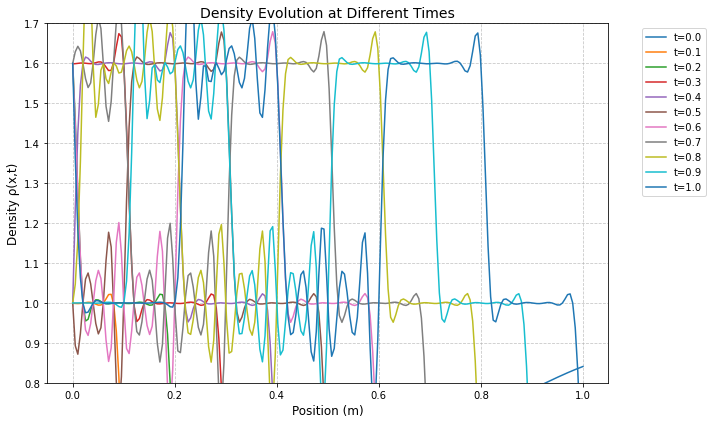

In [37]:
# Define the time snapshots you want to plot
time_snapshots = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
x_vals = np.linspace(0, L_finale, 200)  # More points for smoother curves

plt.figure(figsize=(10, 6))

for t_val in time_snapshots:
    # Create (x, t) pairs for this snapshot
    x_grid = np.expand_dims(x_vals, axis=1)
    t_grid = np.full_like(x_grid, t_val)
    xt = np.concatenate([x_grid, t_grid], axis=1)
    
    # Create time sequence
    xt_seq = make_time_sequence(xt, num_step=5, step=1e-4)
    xt_seq_tensor = torch.tensor(xt_seq, dtype=torch.float32).to(device)
    
    # Split into x and t for the model
    x_seq = xt_seq_tensor[:, :, 0:1]
    t_seq = xt_seq_tensor[:, :, 1:2]
    
    with torch.no_grad():
        u_pred = model(x_seq, t_seq)[:, 0].cpu().numpy()
    plt.plot(x_vals, u_pred, label=f't={t_val:.1f}')

plt.xlabel('Position (m)', fontsize=12)
plt.ylabel('Density ρ(x,t)', fontsize=12)
plt.title('Density Evolution at Different Times', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylim(0.8, 1.7)  # Set y-limits based on your density range
plt.tight_layout()
plt.show()

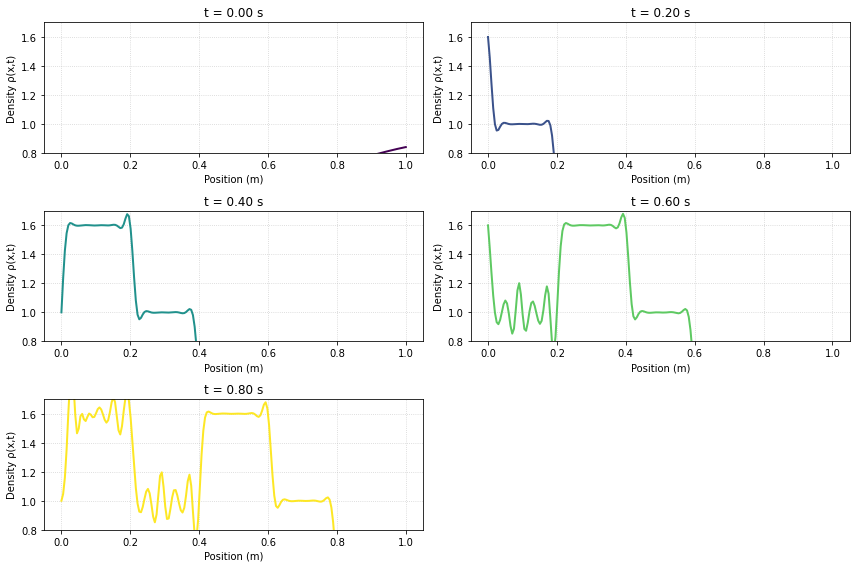

In [38]:
# Evaluation & Visualisation – separate line plots at each snapshot
import matplotlib.cm as cm

# Spatial grid for line plots
x_vals = np.linspace(0, L_finale, 200)
snapshot_times = torch.arange(0, T_final, T_periode, device=device)
colors = cm.viridis(np.linspace(0, 1, len(snapshot_times)))

plt.figure(figsize=(12, 8))

for idx, (t_val, color) in enumerate(zip(snapshot_times, colors)):
    # Create (x, t) pairs for this snapshot
    x_grid = np.expand_dims(x_vals, axis=1)
    t_grid = np.full_like(x_grid, t_val.cpu().numpy())
    xt = np.concatenate([x_grid, t_grid], axis=1)
    
    # Create time sequence
    xt_seq = make_time_sequence(xt, num_step=5, step=1e-4)
    xt_seq_tensor = torch.tensor(xt_seq, dtype=torch.float32).to(device)
    
    # Split into x and t for the model
    x_seq = xt_seq_tensor[:, :, 0:1]
    t_seq = xt_seq_tensor[:, :, 1:2]
    
    plt.subplot(3, 2, idx + 1)
    with torch.no_grad():
        u_pred = model(x_seq, t_seq)[:, 0].cpu().numpy()
    plt.plot(x_vals, u_pred, color=color, linewidth=2)
    plt.xlabel('Position (m)', fontsize=10)
    plt.ylabel('Density ρ(x,t)', fontsize=10)
    plt.title(f't = {t_val.item():.2f} s', fontsize=12)
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.ylim(0.8, 1.7)

plt.tight_layout()
plt.show()

In [138]:
import matplotlib.animation as animation
from IPython.display import HTML

# Create high-resolution spatial grid for animation
x_vals = np.linspace(0, L_finale, 200)
snapshot_times = torch.linspace(0, T_final, 50, device=device)  # 50 frames for smooth animation

# Set up the figure
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlabel('Position (m)', fontsize=12)
ax.set_ylabel('Density ρ(x,t)', fontsize=12)
ax.set_title('Density Evolution Over Time', fontsize=14)
ax.grid(True, linestyle='--', alpha=0.6)
ax.set_xlim(0, L_finale)
ax.set_ylim(0.8, 1.7)

line, = ax.plot([], [], 'b-', linewidth=2)
time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes, fontsize=12,
                   bbox=dict(facecolor='white', alpha=0.8))

def init():
    line.set_data([], [])
    time_text.set_text('')
    return line, time_text

def animate(i):
    t_val = snapshot_times[i]
    
    # Create input data
    x_grid = np.expand_dims(x_vals, axis=1)
    t_grid = np.full_like(x_grid, t_val.cpu().numpy())
    xt = np.concatenate([x_grid, t_grid], axis=1)
    
    # Create time sequence
    xt_seq = make_time_sequence(xt, num_step=5, step=1e-4)
    xt_seq_tensor = torch.tensor(xt_seq, dtype=torch.float32).to(device)
    
    with torch.no_grad():
        u_pred = model2(xt_seq_tensor[:, :, 0:1], xt_seq_tensor[:, :, 1:2])[:, 0].cpu().numpy()
    
    line.set_data(x_vals, u_pred)
    time_text.set_text(f'Time: {t_val.item():.2f} s')
    return line, time_text

ani = animation.FuncAnimation(
    fig, animate, frames=len(snapshot_times),
    init_func=init, blit=True, interval=50
)

plt.close()
HTML(ani.to_jshtml())

In [39]:
import matplotlib.animation as animation
from IPython.display import HTML

x_line = torch.linspace(0, L_finale, 500, device=device).view(-1, 1)
snapshot_times = torch.arange(0, T_final+1, 0.1, device=device)  # Smaller time steps

# Set up the figure
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlabel("Position (m)", fontsize=12)
ax.set_ylabel("Density ρ(x,t)", fontsize=12)
ax.set_title("Density Evolution Over Time", fontsize=14)
ax.grid(True, linestyle='--', alpha=0.6)
ax.set_xticks(torch.linspace(0, L_finale, steps=6).tolist())
ax.tick_params(axis='x', labelsize=10)

# Create animation elements
line, = ax.plot([], [], 'b-', linewidth=2)
time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes, fontsize=12,
                   bbox=dict(facecolor='white', alpha=0.8))

# Set axis limits
ax.set_xlim(0, L_finale)
ax.set_ylim(0.8, 1.7)

def init():
    line.set_data([], [])
    time_text.set_text('')
    return line, time_text

def animate(i):
    t_val = snapshot_times[i]
    
    # Create proper input format for the model
    x_grid = x_line.cpu().numpy()
    t_grid = np.full_like(x_grid, t_val.cpu().numpy())
    xt = np.concatenate([x_grid, t_grid], axis=1)
    
    # Create time sequence
    xt_seq = make_time_sequence(xt, num_step=5, step=1e-4)
    xt_seq_tensor = torch.tensor(xt_seq, dtype=torch.float32).to(device)
    
    # Split into x and t for the model
    x_seq = xt_seq_tensor[:, :, 0:1]
    t_seq = xt_seq_tensor[:, :, 1:2]
    
    with torch.no_grad():
        u_pred_line = model(x_seq, t_seq)[:, 0].cpu().numpy()
    
    line.set_data(x_line.cpu().numpy().flatten(), u_pred_line)
    time_text.set_text(f'Time: {t_val.item():.2f} s')
    
    return line, time_text

# Create animation
ani = animation.FuncAnimation(
    fig, animate, frames=len(snapshot_times),
    init_func=init, blit=True, interval=100  # Reduced interval for smoother animation
)

plt.close(fig)
HTML(ani.to_jshtml())

In [ ]:
loss_track = []

for i in tqdm(range(500)):
    def closure():
        pred_res = model(x_res, t_res)
        pred_end = model(x_x_end, t_x_end)
        pred_start = model(x_x_start, t_x_start)

        pred_initial = model(x_t_initial, t_t_initial)
        u_x = torch.autograd.grad(pred_res, x_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]
        u_t = torch.autograd.grad(pred_res, t_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]

        loss_res = torch.mean((u_t + Beta * u_x) ** 2)
        loss_bc = torch.mean((get_density(t_x_end) - pred_start) ** 2)
        loss_ic = torch.mean((pred_initial - Rho_i) ** 2)

        loss_track.append([loss_res.item(), loss_bc.item(), loss_ic.item()])

        loss = loss_res + loss_bc + loss_ic
        optim.zero_grad()
        loss.backward()
        return loss
    
    optim.step(closure)

100%|██████████| 500/500 [06:37<00:00,  1.26it/s]


In [40]:
print('Loss Res: {:4f}, Loss_BC: {:4f}, Loss_IC: {:4f}'.format(loss_track[-1][0], loss_track[-1][1], loss_track[-1][2]))
print('Train Loss: {:4f}'.format(np.sum(loss_track[-1])))

Loss Res: 0.000002, Loss_BC: 0.004901, Loss_IC: 0.004903
Train Loss: 0.009806


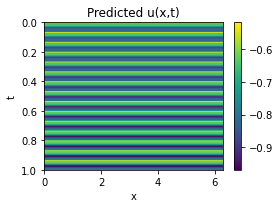

In [34]:
res_test, _, _, _, _ = get_data([0,2*np.pi], [0,1], 15, 15)


# Visualize PINNsformer
res_test = make_time_sequence(res_test, num_step=5, step=1e-4) 
res_test = torch.tensor(res_test, dtype=torch.float32, requires_grad=True).to(device)
x_test, t_test = res_test[:,:,0:1], res_test[:,:,1:2]


with torch.no_grad():
    pred = model2(x_test, t_test)[:,0:1]
    pred = pred.cpu().detach().numpy()

plt.figure(figsize=(4,3))
plt.imshow(pred, extent=[0,np.pi*2,1,0], aspect='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Predicted u(x,t)')
plt.colorbar()
plt.tight_layout()
plt.savefig('./convection_pinnsformer_pred.png')
plt.show()
